# Introduction

In this project, we are going to work on the problem proposed by the [House Prices competition on Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data): to build a model to predict house prices based on its features.

The **data** we are going to look at is the Ames Housing Dataset, which includes 81 features describing a wide range of characteristics of 1,460 homes in Ames, Iowa sold between 2006 and 2010.

Price prediction is a machine learning regression problem where the goal is to predict a continuous value. To address it, we are going to use **XGBoost (eXtreme Gradient Boosting)**, a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models.

Since the database include categorical features (i.e. text), missing values and numerical features of varying scales, we are doing to dedicate some time to **data preparation** before we get to our model. We'll organise these steps in a pipeline to automate and optimize this process.

# Data Exploration

The first step is to explore the dataset and see what we are dealing with.

In [97]:
#Import modules for data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

In [98]:
#Download the data and declare it as a Pandas dataframe
data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv", index_col="Id")
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [99]:
#Declare our features (X) and target (y) dataframes
X = data.drop(columns=['SalePrice'])
y = data.SalePrice
X.shape

(1460, 79)

In [100]:
# Get the data types of the columns in the dataframe
dtypes = data.dtypes
# Count the number of columns of each data type
counts = dtypes.value_counts()
counts

object     43
int64      34
float64     3
dtype: int64

In [117]:
#View numerical features
X_num = X.select_dtypes(include=["int64", "float64"]).columns
X_num

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [120]:
#Count numerical features
X_num.size

36

In [119]:
#View categorical features
X_cat = X.select_dtypes(include=["object"]).columns
X_cat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [121]:
#Count categorical features
X_cat.size

43

In [122]:
#Count the number of unique values across categorical features
feat_categorical_nunique = X.select_dtypes(include='object').nunique()
feat_categorical_nunique.sum()

252

The dataset contains 1460 observations and 80 columns: 79 features and 1 target.

We have 43 categorical features (text) and 36 numerical ones.

Our categorical features contain 252 unique values. If we were to encode all of them - i.e. turn them into numbers that our algorithm can understand - we would end up with hundreds of features which is not good for our model. So let's see how we can reduce them.

# Data Preparation

<AxesSubplot:>

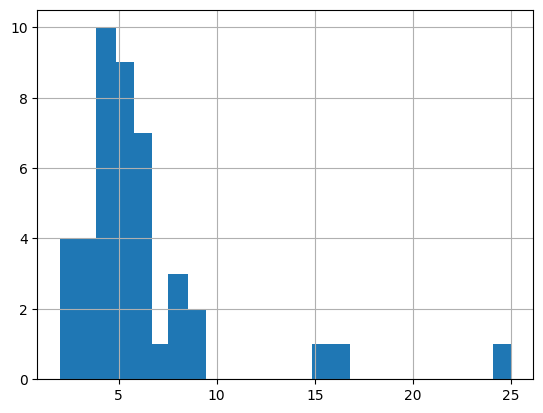

In [123]:
#Plot a histogram with number of features per number of unique values
feat_categorical_nunique.hist(bins=25, width=1)

Most features have fewer than 7 unique values, so let's redefine our X selecting those.

In [105]:
#Select features with fewer than 7 unique values
feat_categorical_nunique

indexes = []

for index, value in feat_categorical_nunique.iteritems():

    if value < 7:

        indexes.append(index)

feat_categorical_small = indexes
feat_categorical_small

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'RoofStyle',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleCondition']

In [128]:
#Declare a new feature set with the reduced feature list
reduced_X = X[['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','BldgType','RoofStyle','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','SaleCondition']]
reduced_X

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,BldgType,RoofStyle,...,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,1Fam,Gable,...,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,1Fam,Gable,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,1Fam,Gable,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,1Fam,Gable,...,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,1Fam,Gable,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,1Fam,Gable,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,1Fam,Gable,...,TA,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,1Fam,Gable,...,Gd,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,Normal


Now, we can build our preprocessing pipeline - i.e. our sequence of steps which will be followed to prepare our features to be fed to our algorithm.

Categorical and numerical features require different preparation, so it is important that we distinguish them. We will use SimpleImputer to replace missing values in both of them. We will also use One Hot Encoder to encode categorical features, and MinMaxScaler to scale numerical features.

In [129]:
#Imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

#Build the preprocessing pipeline for numerical features
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler())

#Build the preprocessing pipeline for categorical features
preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

#Combine them
preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, feat_categorical_small),
    remainder="drop")

#View our preprocessing pipeline
preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x2b69375b0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

Now we have our preprocessing pipeline assembled, we can add out model: the XGB Regressor.

In [130]:
#Import the model
from xgboost import XGBRegressor

#Instantiate the model
model = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)

#Assemble the pipeline
pipe_baseline = Pipeline([
    ('preprocess', preproc_baseline),
    ('regressor', model)
])

#View our complete pipeline
pipe_baseline.fit(reduced_X,y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2b69375b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHot...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=10, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

With our pipeline ready, we can proceed to scoring. The competition determined root mean squared error as the performance metric, but we need to build our scorer before we can cross-validate our pipeline.

In [131]:
#Imports
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

#Declare the scorer with the formula provided
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5,
                    greater_is_better=False)

In [141]:
#Imports
from sklearn.model_selection import cross_val_score

#Cross-validate
cross_val_score(pipe_baseline, reduced_X, y, cv=5, scoring=rmsle)

#Obtain the mean score
score_baseline = np.mean(cross_val_score(pipe_baseline, reduced_X, y, cv=5, scoring=rmsle))
score_baseline

-0.2289446162093854

Et voila, we obtain 0.22 which is considered a good root mean squared error score. Now we can use our pipeline to predict house prices for our test dataset.

In [142]:
#Read the dataset and declare it as a Pandas dataframe
test = pd.read_csv("test.csv")
test

#Predict our target using our pipeline
y_pred_baseline = pipe_baseline.predict(test)
y_pred_baseline

#View the test dataset with calculated prices
test['SalePrice'] = y_pred_baseline
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,132546.031250
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,164296.953125
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,179465.125000
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,191011.609375
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,192644.015625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,97812.546875
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,108139.320312
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,126151.164062
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,141124.578125
